# Determining Best Neighborhood To Locate Store by Neighborhood Clustering

## 1. Import Libraries

In [95]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


# 2. About Current Store Location

### Defining Charecteristics of Vinings Neighbourhood

Vinings is a city located in Cobb County, Georgia. It is predominantly made up of White (52.3%) and Black or African-American (31.8%). With a median age of 34.3 years it is one of the youngest cities to live. Following are the key demographics of Vinings

In [4]:
data={'Population': [13086],
     'Growth Rate (%)': [34.44],
     'Median Age': [34.3],
     'Median HH Income ($)':[79359],
     'Median HH Income ($)':[46201],
     'Unemployment Rate(%)': [2.4],
     'Homeownership Rate(%)': [34.4],
     'Marriage Rate(%)': [40.6]}
data=pd.DataFrame(data).T
data=data.rename(columns={0:'Measure'})
data

,Measure
Population,13086.00
Growth Rate (%),34.44
Median Age,34.30
Median HH Income ($),46201.00
Unemployment Rate(%),2.40
Homeownership Rate(%),34.40
Marriage Rate(%),40.60


#### Sources:
https://www.niche.com/places-to-live/vinings-cobb-ga/residents/  
https://worldpopulationreview.com/us-cities/vinings-ga-population/

### Our Store is located in Cumberland Mall at '2860 Cumberland Mall SE, Atlanta, GA 30339, United States'

In [5]:
latitude = 33.881316
longitude =  -84.470123
print('The geograpical coordinates of our current store are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of our current store are 33.881316, -84.470123.


### First lets us obtain venue profile of other stores in our current neighborhood

In [101]:
# type your answer here
CLIENT_ID = 'VQKPPC2VLDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF' # your Foursquare ID
CLIENT_SECRET = 'L78M5TC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0' # your Foursquare Secret
VERSION = '20200105' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=VQKPPC2VLDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF&client_secret=L78M5TC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0&v=20200105&ll=40.644337,-74.007532&radius=500&limit=100'

In [8]:
results = requests.get(url).json()
# results

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
venues = results['response']['groups'][0]['items']
# venues
nearby_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues['venue.categories']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


0               Restaurant
1           Sandwich Place
2          Warehouse Store
3        Electronics Store
4           Lingerie Store
5       Italian Restaurant
6        Accessories Store
7      American Restaurant
8           Cosmetics Shop
9                 Pharmacy
10              Food Court
11      Chinese Restaurant
12          Clothing Store
13          Cosmetics Shop
14      Seafood Restaurant
15              Shoe Store
16          Cosmetics Shop
17    Other Great Outdoors
18              Shoe Store
19        Department Store
20          Lingerie Store
21          Clothing Store
22                  Bakery
23              Nail Salon
24          Cosmetics Shop
25           Deli / Bodega
26                   Hotel
27                Boutique
28     American Restaurant
29           Smoothie Shop
30     American Restaurant
31             Coffee Shop
32              Restaurant
33          Cosmetics Shop
34           Shopping Mall
35           Jewelry Store
36             Men's Store
3

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Stoney River Legendary Steaks,Restaurant,33.881547,-84.469126
1,F2O - Fresh To Order,Sandwich Place,33.880928,-84.469960
2,Costco,Warehouse Store,33.880940,-84.471113
3,Apple Cumberland Mall,Electronics Store,33.880667,-84.469788
4,Victoria's Secret PINK,Lingerie Store,33.880396,-84.468965


In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

76 venues were returned by Foursquare.


### Venue Profile surrounding our Store

In [13]:
# nearby_venues[['categories']].groupby(['categories']).agg({'count':sum})
nearby_venues.groupby('categories')['categories'].count().sort_values(ascending=False)

categories
Clothing Store          8
Hotel                   5
American Restaurant     5
Cosmetics Shop          5
Jewelry Store           3
Shoe Store              3
Italian Restaurant      2
Kids Store              2
Lingerie Store          2
Men's Store             2
Sandwich Place          2
Wings Joint             2
Bakery                  2
Restaurant              2
Chinese Restaurant      1
Grocery Store           1
Coffee Shop             1
Convention Center       1
Bus Station             1
Deli / Bodega           1
Department Store        1
Breakfast Spot          1
Boutique                1
Bank                    1
Electronics Store       1
Asian Restaurant        1
Food Court              1
Juice Bar               1
Intersection            1
Smoke Shop              1
Video Game Store        1
Theme Restaurant        1
Supplement Shop         1
Spa                     1
Snack Place             1
Smoothie Shop           1
Shopping Mall           1
Warehouse Store         1
S

### It appears that our neighborhood is dominated by Clothing Store, Hotels, Restaurants, American Restaurants,Jewelry, Cosmetics, Shoe Stores majorly

# 3. Analyzing New York City Neighborhoods

In [14]:
# Downloading New York Neighbourhood dataset in geo-json format
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [15]:
# All our relevant data is locatedin 'Features'
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
print('New York City has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

New York City has 5 boroughs and 306 neighborhoods.


#### Ploting Neighborhoods on Map

### The management has already decided to move to Brooklyn. We need to choose best neighborhood in Brooklyn based on venue profile, market size, competitors etc (Red)

In [17]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [18]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [19]:
Brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
Brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


### The Neighborhoods of New York City are plotted below and Brooklyn neighborhoods are highlighted in Green

In [20]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

neighborhoods1= neighborhoods[neighborhoods['Borough']!='Brooklyn']

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods1['Latitude'], neighborhoods1['Longitude'], neighborhoods1['Borough'], neighborhoods1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

for lat, lng, borough, neighborhood in zip(Brooklyn_data['Latitude'], Brooklyn_data['Longitude'], Brooklyn_data['Borough'], Brooklyn_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

    
map_newyork

In [27]:
# Downloading New York Neighbourhood dataset in geo-json format
# !wget -q -O 'test.json' https://opendata.arcgis.com/datasets/34520575dfc34b8cac783caff702b8cc_58.geojson
# with open('test.json') as json_data:
#     test_data = json.load(json_data)


In [45]:
# address = 'Brooklyn, NY'

# geolocator = Nominatim(user_agent="ny_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

In [46]:
# neighborhoods1= neighborhoods[neighborhoods['Borough']!='Brooklyn'].shape

# 4. Analyzing Brooklyn Neighborhood

#### Obtaining List of Venues located in Brooklyn from Foursquare

In [93]:
CLIENT_ID = 'VZQFC2VDDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF' # your Foursquare ID
CLIENT_SECRET = 'L71M5ZC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0' # your Foursquare Secret
VERSION = '20200105' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VZQFC2VDDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF
CLIENT_SECRET:L71M5ZC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0


In [22]:
print(Brooklyn_data.shape)

(70, 4)


### Defining Functions to pull venue data from Foursquare for all neighborhoods in Brooklyn.

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
# type your answer here

Brooklyn_venues = getNearbyVenues(names=Brooklyn_data['Neighborhood'],
                                   latitudes=Brooklyn_data['Latitude'],
                                   longitudes=Brooklyn_data['Longitude']
                                  )


Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [25]:
print(Brooklyn_venues.shape)
Brooklyn_venues.head()

(2733, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [26]:
Brooklyn_venues.groupby('Neighborhood')['Venue Category'].count().sort_values(ascending=False)

Neighborhood
Brooklyn Heights             100
South Side                   100
Carroll Gardens              100
North Side                   100
Downtown                      99
Greenpoint                    97
Cobble Hill                   94
Clinton Hill                  93
Boerum Hill                   90
Bay Ridge                     80
Bushwick                      76
Prospect Heights              75
East Williamsburg             73
Fort Hamilton                 69
Gowanus                       67
Park Slope                    62
Dumbo                         62
Fort Greene                   60
Fulton Ferry                  58
Bath Beach                    51
Red Hook                      50
Prospect Park South           49
Prospect Lefferts Gardens     48
Ditmas Park                   45
Brighton Beach                44
Homecrest                     38
Sunset Park                   37
City Line                     36
Williamsburg                  34
Kensington                    

In [27]:
print('There are {} uniques categories.'.format(len(Brooklyn_venues['Venue Category'].unique())))

There are 285 uniques categories.


North Side, South Side, Carroll Gardens, Brooklyn Heights, Green Point, Cobble Hill are few of the most densely populated Retail Stores 

In [28]:
# one hot encoding
Brooklyn_onehot = pd.get_dummies(Brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Brooklyn_onehot['Neighborhood'] = Brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
# fixed_columns = [Brooklyn_onehot.columns[-1]] + list(Brooklyn_onehot.columns[:-1])
# fixed_columns = ['Neighborhood'] + list(Brooklyn_onehot.columns[:-1])
# Brooklyn_onehot.columns

Brooklyn_onehot=Brooklyn_onehot[['Neighborhood']+[col for col in Brooklyn_onehot.columns if col!='Neighborhood']]
# Brooklyn_onehot = Brooklyn_onehot[fixed_columns]
Brooklyn_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Res

In [29]:
Brooklyn_grouped = Brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
Brooklyn_grouped.head(5)

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Res

In [30]:
Brooklyn_grouped.shape

(70, 285)

Ascessing Top 5 Venues in each neighborhood

In [31]:
num_top_venues = 5

for hood in Brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Brooklyn_grouped[Brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                venue  freq
0         Pizza Place  0.06
1            Pharmacy  0.06
2  Italian Restaurant  0.04
3          Donut Shop  0.04
4     Bubble Tea Shop  0.04


----Bay Ridge----
                venue  freq
0                 Spa  0.06
1         Pizza Place  0.06
2  Italian Restaurant  0.06
3          Bagel Shop  0.05
4    Greek Restaurant  0.04


----Bedford Stuyvesant----
            venue  freq
0     Coffee Shop  0.12
1     Pizza Place  0.08
2             Bar  0.08
3            Café  0.08
4  Discount Store  0.04


----Bensonhurst----
                venue  freq
0  Italian Restaurant  0.10
1          Donut Shop  0.07
2  Chinese Restaurant  0.07
3    Sushi Restaurant  0.07
4      Ice Cream Shop  0.07


----Bergen Beach----
                venue  freq
0     Harbor / Marina  0.33
1      Baseball Field  0.17
2                Park  0.17
3  Athletics & Sports  0.17
4          Playground  0.17


----Boerum Hill----
                    venue  freq
0             Cof

In order to better understand Clustering results we are evaluating top 10 venue categories for each neighborhood

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Brooklyn_grouped['Neighborhood']

for ind in np.arange(Brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Pizza Place,Fast Food Restaurant,Gas Station,Bubble Tea Shop,Donut Shop,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Sports Bar
1,Bay Ridge,Pizza Place,Spa,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Pharmacy,Thai Restaurant,Sushi Restaurant
2,Bedford Stuyvesant,Coffee Shop,Pizza Place,Café,Bar,Juice Bar,Boutique,New American Restaurant,Deli / Bodega,Fried Chicken Joint,Gift Shop
3,Bensonhurst,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Bakery,Donut Shop,Cosmetics Shop,Bagel Shop,Pizza Place,Shabu-Shabu Restaurant
4,Bergen Beach,Harbor / Marina,Park,Baseball Field,Playground,Athletics & Sports,Farmers Market,Event Space,Factory,Falafel Restaurant,Farm


# 5. Neighborhood Clustering

In [34]:
# set number of clusters
kclusters = 10

Brooklyn_grouped_clustering = Brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 2, 3, 0, 5, 2, 5, 2], dtype=int32)

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Brooklyn_merged = Brooklyn_data

# merge Brooklyn_grouped with Brooklyn_data to add latitude/longitude for each neighborhood
Brooklyn_merged = Brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,2,Pizza Place,Spa,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Pharmacy,Thai Restaurant,Sushi Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,2,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Bakery,Donut Shop,Cosmetics Shop,Bagel Shop,Pizza Place,Shabu-Shabu Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,5,Pizza Place,Mobile Phone Shop,Latin American Restaurant,Bank,Bakery,Mexican Restaurant,Fried Chicken Joint,Deli / Bodega,Gym,Video Game Store
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Sushi Restaurant,French Restaurant,Mexican Restaurant,Yoga Studio,Grocery Store,New American Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,2,Pizza Place,Music Venue,Lounge,Bakery,Gym,Spa,Deli / Bodega,Furniture / Home Store,Martial Arts Dojo,Baseball Field


Determining best clusters using Within Cluster Sum of Squares (WCSS)

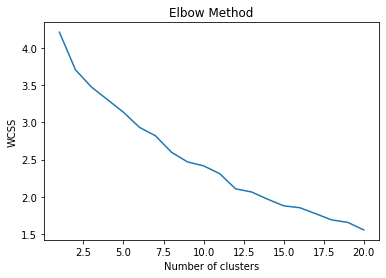

In [36]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    Brooklyn_grouped_clustering = Brooklyn_grouped.drop('Neighborhood', 1)
    kmeans.fit(Brooklyn_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Lets look at Map to see Clustering Results

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [38]:
Brooklyn_merged.groupby('Cluster Labels')['Cluster Labels'].count()

Cluster Labels
0    12
1     1
2    29
3     1
4     1
5    21
6     1
7     1
8     2
9     1
Name: Cluster Labels, dtype: int64

### Majority of Neighborhoods belong either in "Cluster-0" or "CLuster-2" or "Cluster-5". Lets reduce the number of clusters based on WCSS plot and feasibility of studying final clusters to 5 or 6

In [68]:
# set number of clusters
kclusters = 6

Brooklyn_grouped_clustering = Brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 4, 4, 1, 4, 0, 0, 0, 4], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Brooklyn_merged = Brooklyn_data

# merge Brooklyn_grouped with Brooklyn_data to add latitude/longitude for each neighborhood
Brooklyn_merged = Brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,4,Pizza Place,Spa,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Pharmacy,Thai Restaurant,Sushi Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,4,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Bakery,Donut Shop,Cosmetics Shop,Bagel Shop,Pizza Place,Shabu-Shabu Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,0,Pizza Place,Mobile Phone Shop,Latin American Restaurant,Bank,Bakery,Mexican Restaurant,Fried Chicken Joint,Deli / Bodega,Gym,Video Game Store
3,Brooklyn,Greenpoint,40.730201,-73.954241,4,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Sushi Restaurant,French Restaurant,Mexican Restaurant,Yoga Studio,Grocery Store,New American Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,4,Pizza Place,Music Venue,Lounge,Bakery,Gym,Spa,Deli / Bodega,Furniture / Home Store,Martial Arts Dojo,Baseball Field


In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [72]:
Brooklyn_merged.groupby('Cluster Labels')['Cluster Labels'].count()

Cluster Labels
0    30
1     4
2     1
3     1
4    33
5     1
Name: Cluster Labels, dtype: int64

Lets study each of Individual 6 Clusters to better understand them

# 6. Results

### Cluster-0 (Red)

In [73]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]].head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Sunset Park,Pizza Place,Mobile Phone Shop,Latin American Restaurant,Bank,Bakery,Mexican Restaurant,Fried Chicken Joint,Deli / Bodega,Gym,Video Game Store
5,Brighton Beach,Restaurant,Russian Restaurant,Beach,Eastern European Restaurant,Bank,Gourmet Shop,Sushi Restaurant,Mobile Phone Shop,Mediterranean Restaurant,Bakery
7,Manhattan Terrace,Pizza Place,Ice Cream Shop,Donut Shop,Cosmetics Shop,Spa,Jazz Club,Bakery,Bagel Shop,Grocery Store,Steakhouse
8,Flatbush,Coffee Shop,Chinese Restaurant,Mexican Restaurant,Juice Bar,Caribbean Restaurant,Bank,Lounge,Bagel Shop,Donut Shop,Grocery Store
10,East Flatbush,Moving Target,Supermarket,Liquor Store,Caribbean Restaurant,Park,Chinese Restaurant,Fast Food Restaurant,Pharmacy,Department Store,Food & Drink Shop
14,Brownsville,Chinese Restaurant,Moving Target,Spanish Restaurant,Fried Chicken Joint,Playground,Pizza Place,Convenience Store,Pharmacy,Restaurant,Performing Arts Venue
25,Cypress Hills,Fried Chicken Joint,Spanish Restaurant,Latin American Restaurant,Pizza Place,Ice Cream Shop,Donut Shop,Fast Food Restaurant,Metro Station,Coffee Shop,Discount Store
26,East New York,Deli / Bodega,Asian Restaurant,Fried Chicken Joint,Metro Station,Bus Station,Fast Food Restaurant,Caribbean Restaurant,Latin American Restaurant,Music Venue,Plaza
27,Starrett City,Supermarket,Pharmacy,Liquor Store,Caribbean Restaurant,Pizza Place,American Restaurant,Convenience Store,Bus Stop,Bus Station,River
29,Flatlands,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Fast Food Restaurant,Nightclub,Lounge,Bar,Paper / Office Supplies Store,Park,Chinese Restaurant


Cluster-0 is dominated by Pizza, Various restaurant types like Chinese, Spanish, Caribbean, Russian. We also have Cosmetics shop, American Restaurant. Around 30 neighborhoods are part of this cluster. 'Flatbush', 'Sunset Park' are most densely populated

### Cluster-1 (Purple)

In [74]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 1, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]].head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Manhattan Beach,Café,Sandwich Place,Bus Stop,Food,Ice Cream Shop,Playground,Beach,Harbor / Marina,Factory,Falafel Restaurant
35,Dyker Heights,Dance Studio,Park,Golf Course,Burger Joint,Bagel Shop,Bus Station,Fast Food Restaurant,Factory,Falafel Restaurant,Farm
39,Sea Gate,Spa,Sports Club,American Restaurant,Beach,Bus Station,Field,Factory,Falafel Restaurant,Farm,Farmers Market
45,Bergen Beach,Harbor / Marina,Park,Baseball Field,Playground,Athletics & Sports,Farmers Market,Event Space,Factory,Falafel Restaurant,Farm


Cluster-1 has total of 4 neighborhoods only and is made up Open spaces like Park, Sports Club, Marina, Playground

### Cluster-2 (Blue)

In [75]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 2, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]].head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Canarsie,Caribbean Restaurant,Asian Restaurant,Grocery Store,Gym,Thai Restaurant,Food,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field


There is only 1 neighborhood in this cluster and top venues are Fish Market, Caribbean Restaurant, Grocery Store, Farm and Fields

### Cluster-3 (Aqua)

In [76]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 3, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]].head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Midwood,Pizza Place,Ice Cream Shop,Pharmacy,Bakery,Video Game Store,Candy Store,Convenience Store,Fish Market,Fish & Chips Shop,Flower Shop


The key distinguishing features include presence of Pizza Place, Ice Cream shop, Bakery and Pharmacy

### Cluster-4 (Green)

In [78]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 4, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]].head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Pizza Place,Spa,Italian Restaurant,Bagel Shop,Greek Restaurant,American Restaurant,Bar,Pharmacy,Thai Restaurant,Sushi Restaurant
1,Bensonhurst,Italian Restaurant,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Bakery,Donut Shop,Cosmetics Shop,Bagel Shop,Pizza Place,Shabu-Shabu Restaurant
3,Greenpoint,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Sushi Restaurant,French Restaurant,Mexican Restaurant,Yoga Studio,Grocery Store,New American Restaurant
4,Gravesend,Pizza Place,Music Venue,Lounge,Bakery,Gym,Spa,Deli / Bodega,Furniture / Home Store,Martial Arts Dojo,Baseball Field
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Sandwich Place,Yoga Studio,Grocery Store,Creperie,Pizza Place,Diner,Restaurant,Russian Restaurant
9,Crown Heights,Pizza Place,Café,Museum,Bakery,Deli / Bodega,Bagel Shop,Burger Joint,Bus Station,Fried Chicken Joint,Supermarket
11,Kensington,Grocery Store,Thai Restaurant,Ice Cream Shop,Pizza Place,Bakery,Gas Station,Restaurant,Outdoors & Recreation,Furniture / Home Store,Mexican Restaurant
12,Windsor Terrace,Park,Plaza,Diner,Grocery Store,Café,Butcher,Chinese Restaurant,Sushi Restaurant,Bookstore,Bakery
13,Prospect Heights,Bar,Mexican Restaurant,Café,Cocktail Bar,Bakery,Thai Restaurant,Wine Shop,Gourmet Shop,Ice Cream Shop,Japanese Restaurant
15,Williamsburg,Coffee Shop,Bar,Bagel Shop,Middle Eastern Restaurant,Korean Restaurant,Tapas Restaurant,Latin American Restaurant,Taco Place,Liquor Store,Lounge


There are 33 neighborhoods in here and is dominated by Pizza, Park, Cafe, Lounge. we also see presence of American, Italien restaurants. 'Willamsburg', 'Bedford Stuyvesant' ,'Bensonhurst' are top neighborhoods in terms of population

### Cluster-5 (Orange)

In [79]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 5, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]].head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Mill Island,Pool,Other Repair Shop,Yoga Studio,Fast Food Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Field


Last Cluster is made of only 1 neighborhood consisting of Pool, Yoga Studio, Factory

# 7. Discussion

### Upon comparing with Vinings neighborhood profile we see that "Cluster-0" and "Cluster-4" are most similar to it due to presence of Sandwich, Spa, Italian, American Restaurants and Pizza stores

### Now in order to determine best site, we first identify top neighborhoods based on demographic count. We want to locate our store in densely populated location so that we can witness high foot traffic

In [81]:
Brooklyn_merged[Brooklyn_merged['Cluster Labels'] == 0]['Neighborhood'].unique()

array(['Sunset Park', 'Brighton Beach', 'Manhattan Terrace', 'Flatbush',
       'East Flatbush', 'Brownsville', 'Cypress Hills', 'East New York',
       'Starrett City', 'Flatlands', 'Coney Island', 'Bath Beach',
       'Borough Park', 'Ocean Hill', 'City Line', 'Prospect Park South',
       'Georgetown', 'Ocean Parkway', 'Fort Hamilton', 'Ditmas Park',
       'Wingate', 'Rugby', 'Remsen Village', 'New Lots',
       'Paerdegat Basin', 'Mill Basin', 'Broadway Junction', 'Homecrest',
       'Highland Park', 'Erasmus'], dtype=object)

In [82]:
Brooklyn_merged[Brooklyn_merged['Cluster Labels'] == 4]['Neighborhood'].unique()

array(['Bay Ridge', 'Bensonhurst', 'Greenpoint', 'Gravesend',
       'Sheepshead Bay', 'Crown Heights', 'Kensington', 'Windsor Terrace',
       'Prospect Heights', 'Williamsburg', 'Bushwick',
       'Bedford Stuyvesant', 'Brooklyn Heights', 'Cobble Hill',
       'Carroll Gardens', 'Red Hook', 'Gowanus', 'Fort Greene',
       'Park Slope', 'Gerritsen Beach', 'Marine Park', 'Clinton Hill',
       'Downtown', 'Boerum Hill', 'Prospect Lefferts Gardens',
       'East Williamsburg', 'North Side', 'South Side', 'Fulton Ferry',
       'Vinegar Hill', 'Weeksville', 'Dumbo', 'Madison'], dtype=object)

### 'Bedford Stuyvesant','Williamsburg','Flatbush','Sunset Park','Bensonhurst' are top neighborhoods in terms of market size from above two clusters 
Source: 'https://statisticalatlas.com/county-subdivision/New-York/Kings-County/Brooklyn/Population#figure/neighborhood/total-population'

### We examine top two neighborhoods from each of the two clusters. From Cluster-4 we shall analyze 'Bedford Stuyvesant' and 'Willamsburg' while from Cluster-0 it will be 'Flatbush' and 'Sunset Park'

## Competitor Presence (1000 meters)

### 1. 'Bedford Stuyvesant, Brooklyn, NY'

In [97]:
address = 'Bedford Stuyvesant, Brooklyn, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

search_query = 'Furniture'
radius = 1000
limit=100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
print(url)
results = requests.get(url).json()
# results
# assign relevant part of JSON to venues
venues = results['response']['venues']
# tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head()

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(10)

40.6834364 -73.9412488
https://api.foursquare.com/v2/venues/search?client_id=VQQFC2VLDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF&client_secret=L51M5TC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0&ll=40.6834364,-73.9412488&v=20200105&query=Furniture&radius=1000&limit=100


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,id
0,Ashley's Furniture,Furniture / Home Store,40.679990,-73.950956,"[{'label': 'display', 'lat': 40.67998962480982...",904,10451,US,Bronx,NY,United States,"[Bronx, NY 10451, United States]",NaN,4f440cb5e4b0c2ab9b839772
1,Rico Furniture,None,40.677599,-73.933573,"[{'label': 'display', 'lat': 40.677599, 'lng':...",917,11213,US,Brooklyn,NY,United States,"[Atlantic Avenue, Brooklyn, NY 11213, United S...",Atlantic Avenue,4bafbe4af964a5200a1d3ce3
2,Lawrence Furniture,Furniture / Home Store,40.680783,-73.952503,"[{'label': 'display', 'lat': 40.680783, 'lng':...",994,11216,US,Brooklyn,NY,United States,"[Brooklyn, NY 11216, United States]",NaN,509fe41be4b0912bf3b64acd
3,King's Furniture,Furniture / Home Store,40.680611,-73.952643,"[{'label': 'display', 'lat': 40.68061115486370...",1012,11216,US,Brooklyn,NY,United States,"[Brooklyn, NY 11216, United States]",NaN,4c5ee80c6147be9a20ff9509


In [84]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Bedford Stuyvesant, Brooklyn, NY

# add a red circle marker to represent the Bedford Stuyvesant
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Bedford Stuyvesant',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Furniture Stores as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### 2. Williamsburg, Brooklyn, NY

In [98]:
address = 'Williamsburg, Brooklyn, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

search_query = 'Furniture'
radius = 1000
limit=100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
print(url)
results = requests.get(url).json()
# results
# assign relevant part of JSON to venues
venues = results['response']['venues']
# tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head()

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(10)

40.714622 -73.95345
https://api.foursquare.com/v2/venues/search?client_id=VQQFC2VLDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF&client_secret=L51M5TC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0&ll=40.714622,-73.95345&v=20200105&query=Furniture&radius=1000&limit=100


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,White Furniture,Furniture / Home Store,N 11th St.,40.719423,-73.954629,"[{'label': 'display', 'lat': 40.71942257853239...",543,11211,US,New York,NY,United States,"[N 11th St., New York, NY 11211, United States]",NaN,4b957d69f964a5205ea534e3
1,Lee's Furniture,Furniture / Home Store,517 Grand,40.711257,-73.950539,"[{'label': 'display', 'lat': 40.711257, 'lng':...",447,11211,US,Brooklyn,NY,United States,"[517 Grand, Brooklyn, NY 11211, United States]",NaN,4c1106f36b7e2d7fca872835
2,Graham Furniture,Furniture / Home Store,524 Grand St,40.710785,-73.950348,"[{'label': 'display', 'lat': 40.71078491210937...",500,11211,US,Brooklyn,NY,United States,"[524 Grand St, Brooklyn, NY 11211, United States]",NaN,4e3af81eb61c338ff58ca07c
3,S&S Furniture,Furniture / Home Store,306 Penn Street,40.705883,-73.952608,"[{'label': 'display', 'lat': 40.705883, 'lng':...",975,11211,US,New York,NY,United States,"[306 Penn Street (Broadway), New York, NY 1121...",Broadway,595bdc977b2e04644ba510cd
4,"iFurniture Seating, Inc.",Furniture / Home Store,890 Metropolitan Ave,40.714260,-73.939496,"[{'label': 'display', 'lat': 40.71425999999999...",1178,11211,US,Brooklyn,NY,United States,"[890 Metropolitan Ave, Brooklyn, NY 11211, Uni...",NaN,57835075498e9274e83c81c4


In [86]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Williamsburg, Brooklyn, NY

# add a red circle marker to represent the Williamsburg
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Williamsburg',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Furniture Stores as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### 3.Flatbush,Brooklyn, NY

In [99]:
address = 'Flatbush, Brooklyn, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

search_query = 'Furniture'
radius = 1000
limit=100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
print(url)
results = requests.get(url).json()
# results
# assign relevant part of JSON to venues
venues = results['response']['venues']
# tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head()

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(5)

40.6520481 -73.959027
https://api.foursquare.com/v2/venues/search?client_id=VQQFC2VLDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF&client_secret=L51M5TC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0&ll=40.6520481,-73.959027&v=20200105&query=Furniture&radius=1000&limit=100


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,crossStreet,id
0,m&m furniture,Furniture / Home Store,40.649680,-73.961110,"[{'label': 'display', 'lat': 40.64968, 'lng': ...",316,11226,US,Brooklyn,NY,United States,"[Brooklyn, NY 11226, United States]",NaN,NaN,4f91dedce4b003d8230477fa
1,"Courts (Furniture, Electronics, & Appliances)",Furniture / Home Store,40.650436,-73.950608,"[{'label': 'display', 'lat': 40.650436, 'lng':...",733,11226,US,Brooklyn,NY,United States,"[2822 Church Ave (Nostrand & Rogers), Brooklyn...",2822 Church Ave,Nostrand & Rogers,4c7f9332d860b60ca32a619d


In [88]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Flatbush, Brooklyn, NY

# add a red circle marker to represent the Flatbush
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Flatbush',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Furniture Stores as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

## 4. Sunset Park, Brooklyn, NY

In [100]:
address = 'Sunset Park, Brooklyn, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

search_query = 'Furniture'
radius = 1000
limit=100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
print(url)
results = requests.get(url).json()
# results
# assign relevant part of JSON to venues
venues = results['response']['venues']
# tranform venues into a dataframe
dataframe = json_normalize(venues)
# dataframe.head()

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(10)

40.644337 -74.007532
https://api.foursquare.com/v2/venues/search?client_id=VQQFC2VLDHIKFRRDTSU34M5ILPVZDBZOC4F1MAIK0FL4SAPF&client_secret=L51M5TC3TGXPJQOJWT3LGMN0VUYRAOM2IC5ZGZWGVAOICAP0&ll=40.644337,-74.007532&v=20200105&query=Furniture&radius=1000&limit=100


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,crossStreet,id
0,Flamingo Furniture Warehouse,Furniture / Home Store,40.643990,-74.011481,"[{'label': 'display', 'lat': 40.64399012778662...",335,11220,US,Brooklyn,NY,United States,"[Brooklyn, NY 11220, United States]",NaN,NaN,4c7f8baed860b60c1c13619d
1,Good & More Furniture,Furniture / Home Store,40.643035,-74.001311,"[{'label': 'display', 'lat': 40.643035, 'lng':...",545,11220,US,Brooklyn,NY,United States,"[4605 8th Ave, Brooklyn, NY 11220, United States]",4605 8th Ave,NaN,4e88d3a95c5c147ccd388c88
2,Best Luck Furniture,Furniture / Home Store,40.639709,-74.005325,"[{'label': 'display', 'lat': 40.63970947265625...",547,11220,US,Brooklyn,NY,United States,"[Brooklyn, NY 11220, United States]",NaN,NaN,5132469ee4b09cc361cd7e8e
3,Liberty Furniture,Furniture / Home Store,40.641441,-74.016061,"[{'label': 'display', 'lat': 40.641441, 'lng':...",789,11220,US,Brooklyn,NY,United States,"[5813 4th Ave, Brooklyn, NY 11220, United States]",5813 4th Ave,NaN,4c5d65486ebe2d7f709dd22e
4,Joe's Furniture Inc,Furniture / Home Store,40.641524,-74.017298,"[{'label': 'display', 'lat': 40.641524, 'lng':...",882,11220,US,Brooklyn,NY,United States,"[5813 4th Ave (Btwn 58th st and 59th st), Broo...",5813 4th Ave,Btwn 58th st and 59th st,5238ac2411d2a1e91b1b0589
5,Bagnato Furniture,Furniture / Home Store,40.647067,-73.996518,"[{'label': 'display', 'lat': 40.647067, 'lng':...",978,11232,US,Brooklyn,NY,United States,"[821 39th St (btwn 8th Ave. & 9th Ave.), Brook...",821 39th St,btwn 8th Ave. & 9th Ave.,4ddc21f6c65bfd579e0c1c3b
6,All Kinda Furniture,Flea Market,40.637969,-74.017432,"[{'label': 'display', 'lat': 40.637969, 'lng':...",1096,NaN,US,Brooklyn,NY,United States,"[Brooklyn, NY, United States]",NaN,NaN,53936eb0498e14bd1c8efd55


In [90]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Sunset Park, Brooklyn, NY

# add a red circle marker to represent the Sunset Park
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Sunset Park',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Furniture Stores as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

# 8. Conclusions

1. 'Flatbush' is the best place due to few competitors in vicinity and high population. Alternatively North or Central 'Bedford Stuyvesant' would also be a convinient choice
2. Locations around 'Sunset Park','Williamsburg' have significant competitive presence and can hurt our margins if operating in same market
3. Analyze Previous Store Closures in the neighborhood 
3. Carryout out a more comprehensive analysis of your competitors based on Value Proposition, Products and Target Customers for final site location 